In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [21]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
#total no. of dates recorded #practise code 
session.query(func.count(measurement.date)).all()

[(19550,)]

In [28]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"the most recent date in the data set is: {recent_date}")

the most recent date in the data set is: ('2017-08-23',)


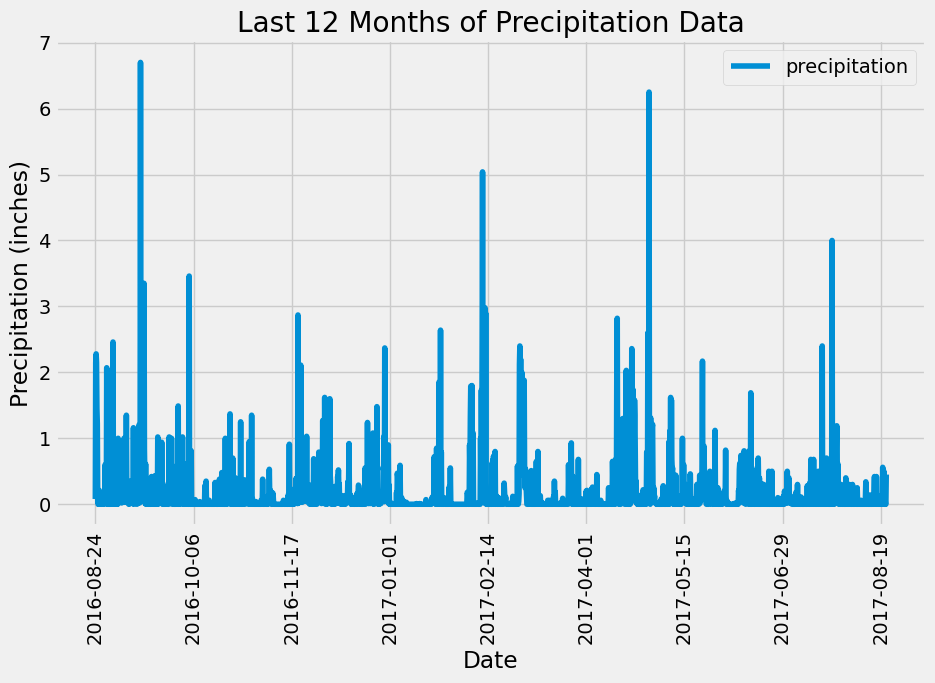

In [42]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in the dataset.
last_date = session.query(func.max(measurement.date)).scalar()

# Calculate the date one year from the last date in the dataset
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation']).set_index('date')

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='date').dropna()
precipitation_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title='Last 12 Months of Precipitation Data', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
station_total = session.query(station.id).count()
print(f"the total number of stations in the dataset is: {station_total}")

the total number of stations in the dataset is: 9


In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).first()
print(f"the most active station is : {most_active_station}")

#extract the station number from the most_active_station variable
most_active_station_no = most_active_station[0]
print(f"the most active station number is : {most_active_station_no}")

#lowest temp recorded
lowest_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == most_active_station_no).all()
print(f"the lowest temperature recorded is {lowest_temp}")

#hightest temp recorded
highest_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == most_active_station_no).all()
print(f"the highest temperature recorded is {highest_temp}")

the most active station is : ('USC00519281', 2772)
the most active station number is : USC00519281
the lowest temperature recorded is [(54.0,)]
the highest temperature recorded is [(85.0,)]


The most recent date for the most active station id is: ('2017-08-18', 79.0)


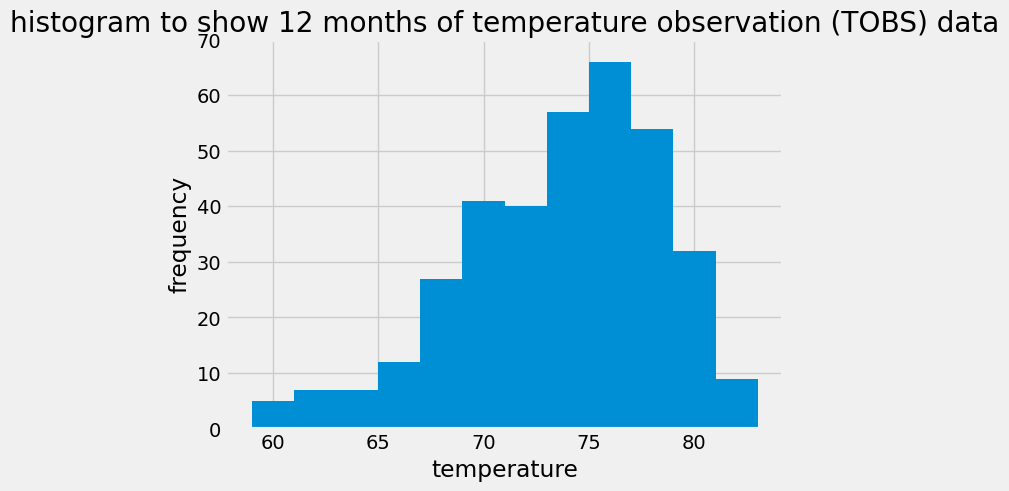

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recent_date_query = (
    session.query(measurement.date, measurement.tobs)
    .filter(measurement.station == most_active_station_no)
    .order_by(measurement.date.desc())
    .first()
)

print(f"The most recent date for the most active station id is: {recent_date_query}")

yearly_data_query = (
    session.query(measurement.date, measurement.tobs)
    .filter(measurement.station == most_active_station_no)
    .filter(measurement.date > "2016-08-17")
    .all()
)

# Convert the query result directly to a DataFrame
yearly_data_df = pd.DataFrame(yearly_data_query, columns=["date", "tobs"]).set_index("date")["tobs"]
yearly_data_df

hist=yearly_data_df.hist(bins=12)
plt.xlabel("temperature")
plt.ylabel("frequency")
plt.ylim(0,70)
plt.title("histogram to show 12 months of temperature observation (TOBS) data")

plt.show()

# Close Session

In [62]:
# Close Session
session.close()